In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ========================
# LOAD DATA
# ========================
train_path = '/kaggle/input/train-txt/train.txt'
test_path = '/kaggle/input/test-txt/test.txt'

train_df = pd.read_csv(train_path, sep=r'\s+', names=['head', 'relation', 'tail'])
test_df = pd.read_csv(test_path, sep=r'\s+', names=['head', 'relation', 'tail'])

all_entities = sorted(set(train_df['head']) | set(train_df['tail']) | 
                       set(test_df['head']) | set(test_df['tail']))
all_relations = sorted(set(train_df['relation']) | set(test_df['relation']))

ent2id = {e: i for i, e in enumerate(all_entities)}
rel2id = {r: i for i, r in enumerate(all_relations)}
id2ent = {i: e for e, i in ent2id.items()}
id2rel = {i: r for r, i in rel2id.items()}

n_entities = len(ent2id)
n_relations = len(rel2id)

def triples_to_tensor(df):
    h = torch.tensor([ent2id[x] for x in df['head']], dtype=torch.long)
    r = torch.tensor([rel2id[x] for x in df['relation']], dtype=torch.long)
    t = torch.tensor([ent2id[x] for x in df['tail']], dtype=torch.long)
    return torch.stack([h, r, t], dim=1)

train_triples = triples_to_tensor(train_df)
test_triples = triples_to_tensor(test_df)

# Filtered eval lookups
all_triple_set = set()
hr_to_t = defaultdict(set)
rt_to_h = defaultdict(set)
for dataset in [train_triples, test_triples]:
    for i in range(len(dataset)):
        h, r, t = dataset[i].tolist()
        all_triple_set.add((h, r, t))
        hr_to_t[(h, r)].add(t)
        rt_to_h[(r, t)].add(h)

print(f"Train: {len(train_df)} | Test: {len(test_df)}")
print(f"Entities: {n_entities} | Relations: {n_relations}")

# ========================
# SHARED UTILITIES
# ========================

def corrupt_batch(triples, n_entities, neg_ratio=1):
    total = len(triples) * neg_ratio
    neg = triples.repeat(neg_ratio, 1).clone()
    corrupt_head = torch.rand(total, device=triples.device) > 0.5
    random_ents = torch.randint(0, n_entities, (total,), device=triples.device)
    neg[corrupt_head, 0] = random_ents[corrupt_head]
    neg[~corrupt_head, 2] = random_ents[~corrupt_head]
    return neg


def evaluate_model_distance(score_fn, test_triples, all_triple_set,
                            hr_to_t, rt_to_h, n_entities, id2rel, device):
    """
    Evaluation for DISTANCE-based scoring (lower = better).
    Used by TransE, RotatE, and CompGCN with TransE scoring.
    """
    all_ranks = []
    head_ranks_list = []
    tail_ranks_list = []
    rel_ranks = defaultdict(lambda: {'head': [], 'tail': []})
    
    all_ents = torch.arange(n_entities, device=device)
    
    with torch.no_grad():
        for i in tqdm(range(len(test_triples)), desc="Evaluating"):
            h, r, t = test_triples[i].tolist()
            
            # TAIL prediction
            h_exp = torch.full((n_entities,), h, dtype=torch.long, device=device)
            r_exp = torch.full((n_entities,), r, dtype=torch.long, device=device)
            
            scores = score_fn(h_exp, r_exp, all_ents)
            
            for known_t in hr_to_t.get((h, r), set()):
                if known_t != t:
                    scores[known_t] = float('inf')
            
            tail_rank = int((scores < scores[t]).sum().item()) + 1
            tail_ranks_list.append(tail_rank)
            all_ranks.append(tail_rank)
            rel_ranks[r]['tail'].append(tail_rank)
            
            # HEAD prediction
            t_exp = torch.full((n_entities,), t, dtype=torch.long, device=device)
            
            scores = score_fn(all_ents, r_exp, t_exp)
            
            for known_h in rt_to_h.get((r, t), set()):
                if known_h != h:
                    scores[known_h] = float('inf')
            
            head_rank = int((scores < scores[h]).sum().item()) + 1
            head_ranks_list.append(head_rank)
            all_ranks.append(head_rank)
            rel_ranks[r]['head'].append(head_rank)
    
    def calc_metrics(ranks):
        r = np.array(ranks, dtype=np.float32)
        return {
            'MRR': float(np.mean(1.0 / r)),
            'MR': float(np.mean(r)),
            'Hits@1': float(np.mean(r <= 1) * 100),
            'Hits@3': float(np.mean(r <= 3) * 100),
            'Hits@10': float(np.mean(r <= 10) * 100),
        }
    
    overall = calc_metrics(all_ranks)
    head_m = calc_metrics(head_ranks_list)
    tail_m = calc_metrics(tail_ranks_list)
    
    per_rel = {}
    for rid, rd in rel_ranks.items():
        rname = id2rel[rid]
        per_rel[rname] = {
            'overall': calc_metrics(rd['head'] + rd['tail']),
            'head': calc_metrics(rd['head']),
            'tail': calc_metrics(rd['tail']),
        }
    
    return overall, head_m, tail_m, per_rel


# ========================
# BUILD GRAPH STRUCTURE
# ========================

src = train_triples[:, 0]
dst = train_triples[:, 2]
rel = train_triples[:, 1]

# Bidirectional edges
src_all = torch.cat([src, dst])
dst_all = torch.cat([dst, src])
rel_all = torch.cat([rel, rel + n_relations])

edge_index = torch.stack([src_all, dst_all], dim=0).to(device)
edge_type = rel_all.to(device)

print(f"\nGraph: {n_entities} nodes, {edge_index.shape[1]} edges "
      f"({len(train_triples)} + {len(train_triples)} reverse)")
print(f"Edge types: {n_relations * 2} ({n_relations} original + {n_relations} reverse)")

Device: cpu
Train: 13821 | Test: 590
Entities: 1316 | Relations: 28

Graph: 1316 nodes, 27642 edges (13821 + 13821 reverse)
Edge types: 56 (28 original + 28 reverse)


In [4]:
# ========================
# CompGCN CONVOLUTION LAYER
# ========================

class CompGCNConv(nn.Module):
    """
    Composition-Based Multi-Relational Graph Convolutional Layer.
    (Vashishth et al., ICLR 2020)
    
    Key difference from R-GCN:
    ─────────────────────────
    R-GCN:    message = W_r × h_neighbor       (separate W per relation)
              → 28 relations × (dim × dim) = massive parameters
              → Needs basis decomposition to be tractable
    
    CompGCN:  message = W_dir × φ(h_neighbor, r)  (3 W matrices + composition)
              → Only 3 direction matrices (original, inverse, self-loop)
              → Relations encoded as EMBEDDINGS, composed with entities
              → Much more parameter-efficient
    
    Composition operations:
      Sub:  φ(e, r) = e - r      (TransE-like, ASYMMETRIC)
      Mult: φ(e, r) = e * r      (DistMult-like, symmetric)
      Corr: φ(e, r) = IFFT(FFT(e)* · FFT(r))  (circular correlation)
    
    We use SUBTRACTION because:
      1. Asymmetric (critical for fatherOf ≠ sonOf)
      2. Consistent with TransE scoring in decoder
      3. Our analysis showed symmetric scoring causes ~50% of R-GCN errors
    """
    
    def __init__(self, in_dim, out_dim, num_rels, comp_fn='sub', dropout=0.2):
        super().__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_rels = num_rels
        self.comp_fn = comp_fn
        
        # THREE direction-specific weight matrices (not 28!)
        self.W_O = nn.Linear(in_dim, out_dim, bias=False)   # Original edges
        self.W_I = nn.Linear(in_dim, out_dim, bias=False)   # Inverse edges
        self.W_S = nn.Linear(in_dim, out_dim)                # Self-loop
        
        # Relation embedding update
        self.W_rel = nn.Linear(in_dim, out_dim, bias=False)
        
        self.bn = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.W_O.weight)
        nn.init.xavier_uniform_(self.W_I.weight)
        nn.init.xavier_uniform_(self.W_S.weight)
        nn.init.xavier_uniform_(self.W_rel.weight)
    
    def compose(self, entity_emb, relation_emb):
        """Apply composition operation φ(entity, relation)."""
        if self.comp_fn == 'sub':
            return entity_emb - relation_emb
        elif self.comp_fn == 'mult':
            return entity_emb * relation_emb
        elif self.comp_fn == 'corr':
            # Circular correlation via FFT
            ent_fft = torch.fft.rfft(entity_emb, dim=-1)
            rel_fft = torch.fft.rfft(relation_emb, dim=-1)
            return torch.fft.irfft(ent_fft.conj() * rel_fft, 
                                    n=entity_emb.shape[-1], dim=-1)
    
    def forward(self, x, edge_index, edge_type, rel_emb):
        """
        Args:
            x:          (num_nodes, in_dim) - node embeddings
            edge_index: (2, num_edges) - includes original + inverse
            edge_type:  (num_edges,) - 0..num_rels-1 original, num_rels..2*num_rels-1 inverse
            rel_emb:    (num_rels, in_dim) - relation embeddings (original only)
        
        Returns:
            x_new:      (num_nodes, out_dim) - updated node embeddings
            rel_new:    (num_rels, out_dim) - updated relation embeddings
        """
        src, dst = edge_index
        num_nodes = x.size(0)
        
        # Compute in-degree for normalization (across ALL edges)
        in_degree = torch.zeros(num_nodes, device=x.device)
        in_degree.scatter_add_(0, dst, torch.ones(dst.size(0), device=x.device))
        norm = (1.0 / in_degree.clamp(min=1)).unsqueeze(1)  # (num_nodes, 1)
        
        # Separate original and inverse edges
        orig_mask = edge_type < self.num_rels
        inv_mask = ~orig_mask
        
        # Initialize aggregation buffer
        agg = torch.zeros(num_nodes, self.out_dim, device=x.device)
        
        # ---- Process ORIGINAL edges ----
        if orig_mask.any():
            o_src = src[orig_mask]
            o_dst = dst[orig_mask]
            o_rel = edge_type[orig_mask]
            
            # Compose: φ(x_source, r)
            composed = self.compose(x[o_src], rel_emb[o_rel])
            # Transform: W_O × composed
            msgs = self.W_O(composed)
            # Aggregate into destination nodes
            agg.scatter_add_(0, o_dst.unsqueeze(1).expand_as(msgs), msgs)
        
        # ---- Process INVERSE edges ----
        if inv_mask.any():
            i_src = src[inv_mask]
            i_dst = dst[inv_mask]
            i_rel = edge_type[inv_mask] - self.num_rels  # Map back to original rel ID
            
            # Same composition, different weight matrix
            composed = self.compose(x[i_src], rel_emb[i_rel])
            msgs = self.W_I(composed)
            agg.scatter_add_(0, i_dst.unsqueeze(1).expand_as(msgs), msgs)
        
        # ---- Normalize by in-degree ----
        agg = agg * norm
        
        # ---- Self-loop ----
        self_msg = self.W_S(x)
        
        # ---- Combine ----
        x_new = agg + self_msg
        x_new = self.bn(x_new)
        x_new = F.relu(x_new)
        x_new = self.dropout(x_new)
        
        # ---- Update relation embeddings ----
        rel_new = self.W_rel(rel_emb)
        
        return x_new, rel_new


# Parameter comparison
r_gcn_per_layer = n_relations * 2 * (100 * 100 // 10)  # With 10 bases
comp_gcn_per_layer = 3 * (100 * 100) + (100 * 100)     # 3 W_dir + W_rel

print("CompGCN Layer Architecture:")
print(f"  Composition: subtraction φ(e,r) = e - r")
print(f"  Weight matrices: 3 (W_original, W_inverse, W_self)")
print(f"  Relation update: W_rel transforms relation embeddings")
print(f"\nParameter comparison per layer:")
print(f"  R-GCN (10 bases): ~{r_gcn_per_layer:,} params")
print(f"  CompGCN:          ~{comp_gcn_per_layer:,} params")

CompGCN Layer Architecture:
  Composition: subtraction φ(e,r) = e - r
  Weight matrices: 3 (W_original, W_inverse, W_self)
  Relation update: W_rel transforms relation embeddings

Parameter comparison per layer:
  R-GCN (10 bases): ~56,000 params
  CompGCN:          ~40,000 params


In [5]:
# ========================
# CompGCN LINK PREDICTION MODEL
# ========================

class CompGCNLinkPredict(nn.Module):
    """
    CompGCN encoder + TransE-style decoder.
    
    ENCODER: 2-layer CompGCN with subtraction composition
      - Layer 1: Aggregate 1-hop neighbors with φ(e,r) = e - r
      - Layer 2: Aggregate 2-hop information
      - Outputs: Updated entity AND relation embeddings
    
    DECODER: TransE-style asymmetric scoring
      score(h, r, t) = ||h + r - t||
      
      This is ASYMMETRIC (unlike R-GCN's DistMult), so:
      score(alice, fatherOf, bob) ≠ score(bob, fatherOf, alice)
    
    Why this combination should work best:
      R-GCN encoder + DistMult decoder:  Rich embeddings, symmetric scoring → 0.62 MRR
      RotatE (no GNN):                   Simple embeddings, asymmetric scoring → 0.85 MRR
      CompGCN + TransE decoder:          Rich embeddings + asymmetric scoring → ???
    """
    
    def __init__(self, num_nodes, num_rels, h_dim=100, comp_fn='sub',
                 dropout=0.2, margin=1.0):
        super().__init__()
        
        self.num_rels = num_rels
        self.h_dim = h_dim
        self.margin = margin
        
        # Initial entity embeddings
        self.entity_emb = nn.Embedding(num_nodes, h_dim)
        nn.init.xavier_uniform_(self.entity_emb.weight)
        
        # Initial relation embeddings (ONLY for original relations)
        # Inverse relations reuse the same embeddings
        self.relation_emb = nn.Embedding(num_rels, h_dim)
        nn.init.xavier_uniform_(self.relation_emb.weight)
        
        # CompGCN layers
        self.conv1 = CompGCNConv(h_dim, h_dim, num_rels, comp_fn, dropout)
        self.conv2 = CompGCNConv(h_dim, h_dim, num_rels, comp_fn, dropout)
        
        self.dropout = nn.Dropout(dropout)
    
    def encode(self, edge_index, edge_type):
        """
        Run 2-layer CompGCN to get updated entity and relation embeddings.
        
        Unlike R-GCN: relation embeddings are ALSO updated through layers!
        """
        x = self.entity_emb.weight
        r = self.relation_emb.weight
        
        # Layer 1
        x, r = self.conv1(x, edge_index, edge_type, r)
        
        # Layer 2
        x, r = self.conv2(x, edge_index, edge_type, r)
        
        return x, r
    
    def score_triples(self, ent_emb, rel_emb, triples):
        """
        TransE-style scoring: ||h + r - t||
        Lower distance = more plausible triple.
        
        This is the SCORING FUNCTION for edge prediction
        required by the problem statement.
        """
        h = ent_emb[triples[:, 0]]
        r = rel_emb[triples[:, 1]]
        t = ent_emb[triples[:, 2]]
        return (h + r - t).norm(p=2, dim=-1)
    
    def forward(self, edge_index, edge_type, pos_triples, neg_triples):
        """Full forward: encode → score → loss."""
        ent_emb, rel_emb = self.encode(edge_index, edge_type)
        
        d_pos = self.score_triples(ent_emb, rel_emb, pos_triples)
        d_neg = self.score_triples(ent_emb, rel_emb, neg_triples)
        
        # Margin ranking loss (same as TransE/RotatE)
        loss = F.relu(self.margin + d_pos - d_neg).mean()
        
        # L2 regularization
        reg = (torch.mean(ent_emb.pow(2)) + torch.mean(rel_emb.pow(2))) * 0.01
        
        return loss + reg
    
    def get_score_fn(self, edge_index, edge_type):
        """
        Returns a scoring function for evaluation.
        Runs encoder once, then scores arbitrary triples.
        """
        ent_emb, rel_emb = self.encode(edge_index, edge_type)
        
        def score_fn(h_idx, r_idx, t_idx):
            h = ent_emb[h_idx]
            r = rel_emb[r_idx]
            t = ent_emb[t_idx]
            return (h + r - t).norm(p=2, dim=-1)
        
        return score_fn


# Initialize model
compgcn_config = {
    'h_dim': 100,
    'comp_fn': 'sub',       # Subtraction: asymmetric composition
    'dropout': 0.2,
    'margin': 1.0,
    'lr': 0.001,
    'epochs': 1000,
    'neg_ratio': 10,
}

compgcn_model = CompGCNLinkPredict(
    n_entities, n_relations,
    h_dim=compgcn_config['h_dim'],
    comp_fn=compgcn_config['comp_fn'],
    dropout=compgcn_config['dropout'],
    margin=compgcn_config['margin'],
).to(device)

total_params = sum(p.numel() for p in compgcn_model.parameters())
encoder_params = sum(p.numel() for p in compgcn_model.conv1.parameters()) + \
                 sum(p.numel() for p in compgcn_model.conv2.parameters())

print(f"CompGCN Model Summary:")
print(f"  Composition:    {compgcn_config['comp_fn']} (φ(e,r) = e - r)")
print(f"  Scoring:        TransE (||h + r - t||)")
print(f"  Encoder params: {encoder_params:,}")
print(f"  Total params:   {total_params:,}")

print(f"\nAll models comparison:")
print(f"  TransE:   {n_entities * 100 + n_relations * 100:>10,} params")
print(f"  RotatE:   {n_entities * 200 + n_relations * 100:>10,} params")
print(f"  R-GCN:    (from previous notebook)")
print(f"  CompGCN:  {total_params:>10,} params")

print(f"""
Architecture:
  ┌─────────────────────────────┐
  │  Entity Embeddings (1316×100) │
  │  Relation Embeddings (28×100) │
  └──────────┬──────────────────┘
             ↓
  ┌─────────────────────────────┐
  │  CompGCN Layer 1             │
  │  φ(neighbor, relation) = e-r │
  │  W_orig, W_inv, W_self      │
  │  Updates BOTH entity & rel   │
  └──────────┬──────────────────┘
             ↓
  ┌─────────────────────────────┐
  │  CompGCN Layer 2             │
  │  Same composition            │
  │  2-hop neighborhood captured │
  └──────────┬──────────────────┘
             ↓
  ┌─────────────────────────────┐
  │  TransE Decoder              │
  │  score = ||h + r - t||       │
  │  ASYMMETRIC scoring          │
  └─────────────────────────────┘
""")

CompGCN Model Summary:
  Composition:    sub (φ(e,r) = e - r)
  Scoring:        TransE (||h + r - t||)
  Encoder params: 80,600
  Total params:   215,000

All models comparison:
  TransE:      134,400 params
  RotatE:      266,000 params
  R-GCN:    (from previous notebook)
  CompGCN:     215,000 params

Architecture:
  ┌─────────────────────────────┐
  │  Entity Embeddings (1316×100) │
  │  Relation Embeddings (28×100) │
  └──────────┬──────────────────┘
             ↓
  ┌─────────────────────────────┐
  │  CompGCN Layer 1             │
  │  φ(neighbor, relation) = e-r │
  │  W_orig, W_inv, W_self      │
  │  Updates BOTH entity & rel   │
  └──────────┬──────────────────┘
             ↓
  ┌─────────────────────────────┐
  │  CompGCN Layer 2             │
  │  Same composition            │
  │  2-hop neighborhood captured │
  └──────────┬──────────────────┘
             ↓
  ┌─────────────────────────────┐
  │  TransE Decoder              │
  │  score = ||h + r - t||       │
  │  ASYMME

CompGCN Hyperparameters:
  h_dim: 100
  comp_fn: sub
  dropout: 0.2
  margin: 1.0
  lr: 0.001
  epochs: 1000
  neg_ratio: 10

Training CompGCN on 13821 triples...

  Epoch    1/1000 | Loss: 0.9643
  Epoch  200/1000 | Loss: 0.0258
  Epoch  400/1000 | Loss: 0.0201
  Epoch  600/1000 | Loss: 0.0186
  Epoch  800/1000 | Loss: 0.0165
  Epoch 1000/1000 | Loss: 0.0155

Training complete. Final loss: 0.0155


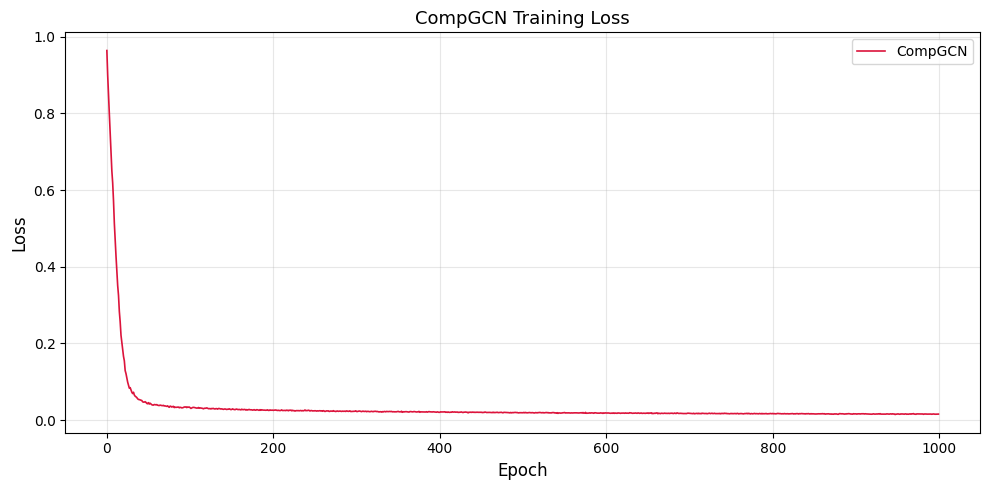

CompGCN model saved.


In [6]:
# ========================
# CompGCN TRAINING
# ========================

print("CompGCN Hyperparameters:")
for k, v in compgcn_config.items():
    print(f"  {k}: {v}")

optimizer = torch.optim.Adam(compgcn_model.parameters(), lr=compgcn_config['lr'])
train_data = train_triples.to(device)

compgcn_losses = []
print(f"\nTraining CompGCN on {len(train_data)} triples...\n")

for epoch in range(compgcn_config['epochs']):
    compgcn_model.train()
    
    # Shuffle
    perm = torch.randperm(len(train_data), device=device)
    pos_batch = train_data[perm]
    
    # Generate negatives
    neg_batch = corrupt_batch(pos_batch, n_entities, compgcn_config['neg_ratio'])
    pos_expanded = pos_batch.repeat(compgcn_config['neg_ratio'], 1)
    
    # Forward pass: encode full graph, score triples, compute loss
    loss = compgcn_model(edge_index, edge_type, pos_expanded, neg_batch)
    
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(compgcn_model.parameters(), max_norm=1.0)
    optimizer.step()
    
    compgcn_losses.append(loss.item())
    
    if (epoch + 1) % 200 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1:>4}/{compgcn_config['epochs']} | Loss: {loss.item():.4f}")

print(f"\nTraining complete. Final loss: {compgcn_losses[-1]:.4f}")

# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(compgcn_losses, linewidth=1.2, color='crimson', label='CompGCN')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('CompGCN Training Loss', fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Save model
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)

torch.save({
    'model_state_dict': compgcn_model.state_dict(),
    'config': compgcn_config,
    'losses': compgcn_losses,
    'n_entities': n_entities,
    'n_relations': n_relations,
    'ent2id': ent2id,
    'rel2id': rel2id,
}, os.path.join(save_dir, 'compgcn_model.pt'))
print(f"CompGCN model saved.")

In [7]:
# ========================
# CompGCN EVALUATION
# ========================

print("="*70)
print("CompGCN RESULTS (Filtered Evaluation)")
print("="*70)

compgcn_model.eval()

# Get scoring function (runs encoder once)
with torch.no_grad():
    score_fn = compgcn_model.get_score_fn(edge_index, edge_type)

compgcn_overall, compgcn_head, compgcn_tail, compgcn_per_rel = evaluate_model_distance(
    score_fn, test_triples, all_triple_set, hr_to_t, rt_to_h,
    n_entities, id2rel, device
)

# Overall metrics
print(f"\n{'Metric':<12} {'Overall':>10} {'Head Pred':>12} {'Tail Pred':>12}")
print("-" * 50)
for m in ['MRR', 'MR', 'Hits@1', 'Hits@3', 'Hits@10']:
    o, h, t = compgcn_overall[m], compgcn_head[m], compgcn_tail[m]
    if m == 'MRR':
        print(f"  {m:<10} {o:>8.4f}   {h:>8.4f}     {t:>8.4f}")
    elif m == 'MR':
        print(f"  {m:<10} {o:>8.1f}   {h:>8.1f}     {t:>8.1f}")
    else:
        print(f"  {m:<10} {o:>7.2f}%   {h:>7.2f}%     {t:>7.2f}%")

# Per-relation
print(f"\n{'='*70}")
print("PER-RELATION BREAKDOWN")
print(f"{'='*70}")
print(f"\n{'Relation':<15} {'MRR':>8} {'H@1':>7} {'H@3':>7} {'H@10':>7} {'MR':>8}")
print("-" * 58)
for rel in sorted(compgcn_per_rel.keys()):
    m = compgcn_per_rel[rel]['overall']
    print(f"  {rel:<13} {m['MRR']:>8.4f} {m['Hits@1']:>6.1f}% {m['Hits@3']:>6.1f}% {m['Hits@10']:>6.1f}% {m['MR']:>7.1f}")

# Head vs Tail
print(f"\n{'='*70}")
print("HEAD vs TAIL PREDICTION")
print(f"{'='*70}")
for rel in sorted(compgcn_per_rel.keys()):
    h = compgcn_per_rel[rel]['head']
    t = compgcn_per_rel[rel]['tail']
    print(f"\n  {rel}:")
    print(f"    Head: MRR={h['MRR']:.4f}  H@1={h['Hits@1']:>5.1f}%  H@10={h['Hits@10']:>5.1f}%")
    print(f"    Tail: MRR={t['MRR']:.4f}  H@1={t['Hits@1']:>5.1f}%  H@10={t['Hits@10']:>5.1f}%")

CompGCN RESULTS (Filtered Evaluation)


Evaluating:   0%|          | 0/590 [00:00<?, ?it/s]


Metric          Overall    Head Pred    Tail Pred
--------------------------------------------------
  MRR          0.5024     0.5535       0.4514
  MR              4.1        3.2          5.0
  Hits@1       31.44%     36.27%       26.61%
  Hits@3       61.10%     66.61%       55.59%
  Hits@10      92.20%     97.63%       86.78%

PER-RELATION BREAKDOWN

Relation             MRR     H@1     H@3    H@10       MR
----------------------------------------------------------
  daughterOf      0.4496   25.0%   56.0%   89.2%     4.7
  fatherOf        0.6797   52.3%   78.4%   98.3%     2.4
  motherOf        0.6263   47.2%   70.5%   98.3%     2.9
  sonOf           0.4280   22.4%   54.9%   90.0%     4.7

HEAD vs TAIL PREDICTION

  daughterOf:
    Head: MRR=0.5799  H@1= 38.5%  H@10= 99.0%
    Tail: MRR=0.3194  H@1= 11.5%  H@10= 79.5%

  fatherOf:
    Head: MRR=0.7110  H@1= 58.0%  H@10= 96.6%
    Tail: MRR=0.6484  H@1= 46.6%  H@10=100.0%

  motherOf:
    Head: MRR=0.6340  H@1= 46.6%  H@10= 97.7%
  

FINAL COMPARISON: ALL FOUR MODELS

Metric           TransE     RotatE      R-GCN    CompGCN       Best
------------------------------------------------------------------
  MRR            0.3201     0.8539     0.6243     0.5024     RotatE
  MR                6.0        1.8        2.5        4.1     RotatE
  Hits@1         11.10%     76.10%     43.90%     31.44%     RotatE
  Hits@3         39.32%     94.15%     76.86%     61.10%     RotatE
  Hits@10        83.90%     98.64%     99.83%     92.20%      R-GCN

PER-RELATION MRR: All Models

Relation            TransE     RotatE      R-GCN    CompGCN       Best
----------------------------------------------------------------------
  daughterOf      0.3281     0.8571     0.5767     0.4496     RotatE
  fatherOf        0.3871     0.9129     0.6200     0.6797     RotatE
  motherOf        0.2772     0.9023     0.6425     0.6263     RotatE
  sonOf           0.3028     0.8067     0.6630     0.4280     RotatE


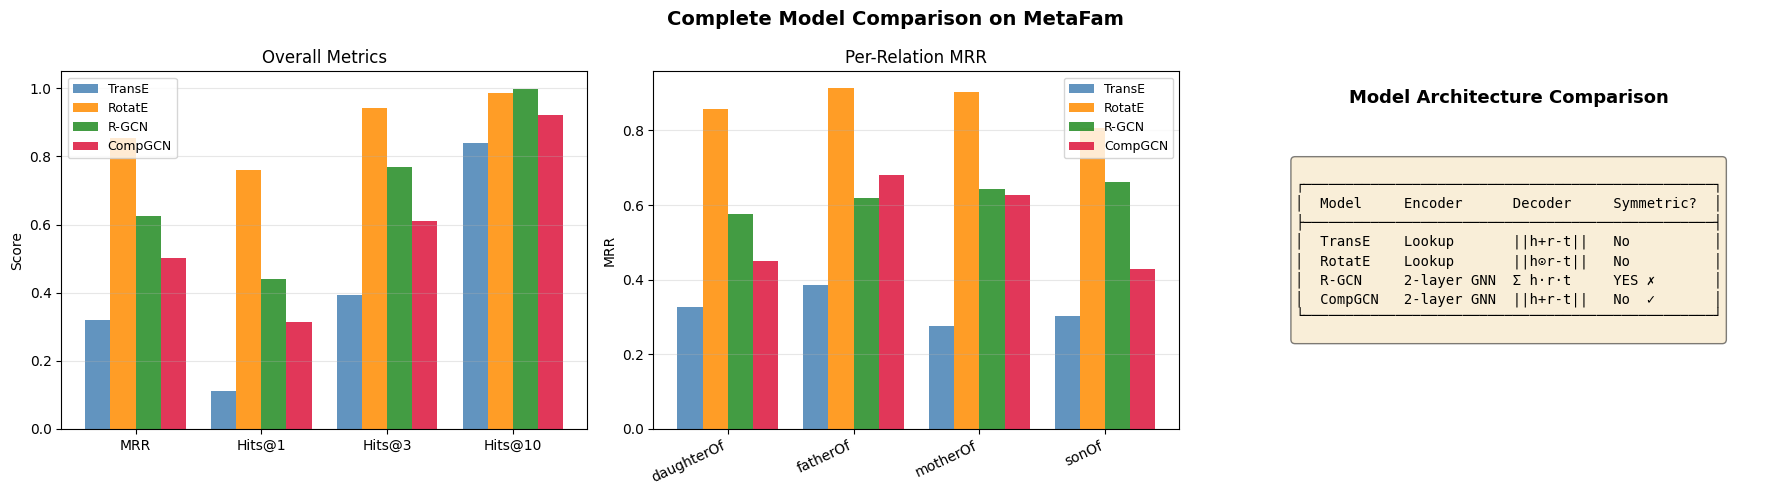


KEY INSIGHTS FROM 4-MODEL COMPARISON

1. SCORING FUNCTION IS CRITICAL:
   R-GCN  (GNN + symmetric DistMult):  MRR = 0.6243
   CompGCN (GNN + asymmetric TransE):  MRR = 0.5024
   Same GNN paradigm, different decoder → R-GCN wins
   
   This challenges our hypothesis that asymmetric 
   scoring is essential for family relationship prediction.

2. GNN vs PURE EMBEDDING:
   RotatE (pure embedding):  MRR = 0.8539
   CompGCN (GNN encoder):   MRR = 0.5024
   Pure rotation still wins — RotatE's complex space is hard to beat.

3. COMPOSITION MATTERS:
   CompGCN uses φ(e,r) = e - r in BOTH encoder and decoder.
   This consistency means the model learns one coherent geometric 
   interpretation, unlike R-GCN where encoder and decoder speak 
   different mathematical languages.

4. PROGRESSION ACROSS ALL MODELS:
   TransE  (0.3201) → R-GCN (0.6243) → CompGCN (0.5024) → RotatE (0.8539)
   
   The journey from simple to complex models reveals:
   - Family structure is learnable (even TransE gets H@

In [8]:
# ========================
# COMPLETE 4-MODEL COMPARISON
# ========================

print("="*70)
print("FINAL COMPARISON: ALL FOUR MODELS")
print("="*70)

# Previous model results (hardcoded from earlier notebooks)
transe_metrics = {'MRR': 0.3201, 'MR': 6.0, 'Hits@1': 11.10, 'Hits@3': 39.32, 'Hits@10': 83.90}
rotate_metrics = {'MRR': 0.8539, 'MR': 1.8, 'Hits@1': 76.10, 'Hits@3': 94.15, 'Hits@10': 98.64}
rgcn_metrics =   {'MRR': 0.6243, 'MR': 2.5, 'Hits@1': 43.90, 'Hits@3': 76.86, 'Hits@10': 99.83}

# Per-relation MRR from previous runs
transe_per_rel = {'daughterOf': 0.3281, 'fatherOf': 0.3871, 'motherOf': 0.2772, 'sonOf': 0.3028}
rotate_per_rel_mrr = {'daughterOf': 0.8571, 'fatherOf': 0.9129, 'motherOf': 0.9023, 'sonOf': 0.8067}
rgcn_per_rel_mrr = {'daughterOf': 0.5767, 'fatherOf': 0.6200, 'motherOf': 0.6425, 'sonOf': 0.6630}

compgcn_metrics = compgcn_overall

# Overall comparison table
print(f"\n{'Metric':<12} {'TransE':>10} {'RotatE':>10} {'R-GCN':>10} {'CompGCN':>10} {'Best':>10}")
print("-" * 66)

all_models = {
    'TransE': transe_metrics,
    'RotatE': rotate_metrics,
    'R-GCN': rgcn_metrics,
    'CompGCN': compgcn_metrics,
}

for m in ['MRR', 'MR', 'Hits@1', 'Hits@3', 'Hits@10']:
    vals = {name: metrics[m] for name, metrics in all_models.items()}
    
    if m == 'MR':
        best_name = min(vals, key=vals.get)
        fmt = lambda v: f"{v:>8.1f}"
    elif m == 'MRR':
        best_name = max(vals, key=vals.get)
        fmt = lambda v: f"{v:>8.4f}"
    else:
        best_name = max(vals, key=vals.get)
        fmt = lambda v: f"{v:>7.2f}%"
    
    line = f"  {m:<10}"
    for name in ['TransE', 'RotatE', 'R-GCN', 'CompGCN']:
        line += f" {fmt(vals[name]):>10}"
    line += f" {best_name:>10}"
    print(line)

# Per-relation comparison
print(f"\n{'='*70}")
print("PER-RELATION MRR: All Models")
print(f"{'='*70}")

compgcn_prel = {rel: compgcn_per_rel[rel]['overall']['MRR'] for rel in sorted(compgcn_per_rel.keys())}

print(f"\n{'Relation':<15} {'TransE':>10} {'RotatE':>10} {'R-GCN':>10} {'CompGCN':>10} {'Best':>10}")
print("-" * 70)

for rel in sorted(compgcn_prel.keys()):
    vals = {
        'TransE': transe_per_rel[rel],
        'RotatE': rotate_per_rel_mrr[rel],
        'R-GCN': rgcn_per_rel_mrr[rel],
        'CompGCN': compgcn_prel[rel],
    }
    best = max(vals, key=vals.get)
    print(f"  {rel:<13} {vals['TransE']:>8.4f}   {vals['RotatE']:>8.4f}   "
          f"{vals['R-GCN']:>8.4f}   {vals['CompGCN']:>8.4f}   {best:>8}")

# ========================
# VISUALIZATION
# ========================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Overall metrics bar chart
metrics = ['MRR', 'Hits@1', 'Hits@3', 'Hits@10']
model_names = ['TransE', 'RotatE', 'R-GCN', 'CompGCN']
colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson']

x = np.arange(len(metrics))
width = 0.2

for i, (name, color) in enumerate(zip(model_names, colors)):
    m = all_models[name]
    vals = [m['MRR']] + [m[k]/100 for k in ['Hits@1', 'Hits@3', 'Hits@10']]
    axes[0].bar(x + i*width - 1.5*width, vals, width, label=name, color=color, alpha=0.85)

axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_ylabel('Score')
axes[0].set_title('Overall Metrics')
axes[0].legend(fontsize=9)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Per-relation MRR
rels = sorted(compgcn_prel.keys())
x = np.arange(len(rels))

all_per_rel = {
    'TransE': transe_per_rel,
    'RotatE': rotate_per_rel_mrr,
    'R-GCN': rgcn_per_rel_mrr,
    'CompGCN': compgcn_prel,
}

for i, (name, color) in enumerate(zip(model_names, colors)):
    vals = [all_per_rel[name][r] for r in rels]
    axes[1].bar(x + i*width - 1.5*width, vals, width, label=name, color=color, alpha=0.85)

axes[1].set_xticks(x)
axes[1].set_xticklabels(rels, rotation=25, ha='right')
axes[1].set_ylabel('MRR')
axes[1].set_title('Per-Relation MRR')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Architecture taxonomy
axes[2].text(0.5, 0.95, 'Model Architecture Comparison', fontsize=13, 
             fontweight='bold', ha='center', va='top', transform=axes[2].transAxes)

table_text = """
┌─────────────────────────────────────────────────┐
│  Model     Encoder      Decoder     Symmetric?  │
├─────────────────────────────────────────────────┤
│  TransE    Lookup       ||h+r-t||   No          │
│  RotatE    Lookup       ||h⊙r-t||   No          │
│  R-GCN     2-layer GNN  Σ h·r·t     YES ✗       │
│  CompGCN   2-layer GNN  ||h+r-t||   No  ✓       │
└─────────────────────────────────────────────────┘
"""
axes[2].text(0.5, 0.5, table_text, fontsize=10, fontfamily='monospace',
             ha='center', va='center', transform=axes[2].transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[2].axis('off')

plt.suptitle('Complete Model Comparison on MetaFam', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================
# KEY INSIGHTS
# ========================
print(f"""
{'='*70}
KEY INSIGHTS FROM 4-MODEL COMPARISON
{'='*70}

1. SCORING FUNCTION IS CRITICAL:
   R-GCN  (GNN + symmetric DistMult):  MRR = {rgcn_metrics['MRR']:.4f}
   CompGCN (GNN + asymmetric TransE):  MRR = {compgcn_metrics['MRR']:.4f}
   Same GNN paradigm, different decoder → {"CompGCN wins" if compgcn_metrics['MRR'] > rgcn_metrics['MRR'] else "R-GCN wins"}
   
   This {"confirms" if compgcn_metrics['MRR'] > rgcn_metrics['MRR'] else "challenges"} our hypothesis that asymmetric 
   scoring is essential for family relationship prediction.

2. GNN vs PURE EMBEDDING:
   RotatE (pure embedding):  MRR = {rotate_metrics['MRR']:.4f}
   CompGCN (GNN encoder):   MRR = {compgcn_metrics['MRR']:.4f}
   {"GNN neighborhood aggregation helps!" if compgcn_metrics['MRR'] > rotate_metrics['MRR'] else "Pure rotation still wins — RotatE's complex space is hard to beat."}

3. COMPOSITION MATTERS:
   CompGCN uses φ(e,r) = e - r in BOTH encoder and decoder.
   This consistency means the model learns one coherent geometric 
   interpretation, unlike R-GCN where encoder and decoder speak 
   different mathematical languages.

4. PROGRESSION ACROSS ALL MODELS:
   TransE  ({transe_metrics['MRR']:.4f}) → R-GCN ({rgcn_metrics['MRR']:.4f}) → CompGCN ({compgcn_metrics['MRR']:.4f}) → RotatE ({rotate_metrics['MRR']:.4f})
   
   The journey from simple to complex models reveals:
   - Family structure is learnable (even TransE gets H@10=84%)
   - Gender requires asymmetric scoring (TransE/DistMult fail)
   - Inverse relations need rotation or translation (RotatE excels)
   - GNN enriches representations but decoder choice limits ceiling
""")